<a href="https://colab.research.google.com/github/Moaaz900/Moaaz/blob/master/BBC_classification_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  **Install huggingface transformer**

In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 66.3 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 3.3 MB 63.6 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Import libraries, transformers and Bert model**



In [2]:
from transformers import BertTokenizer #Import Bert tokenizer from huggingface
from transformers import TFAutoModel # Import Bert models
#Import libraries 
import pandas as pd
import numpy as np
import tensorflow as tf # import tensorflow
#To save checkpoint of model 
import shutil
import sys
#plotly for visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
#scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab import drive
from keras.models import load_model

**Check TF version, Eager mode and TPU**

In [3]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TPU is", "available" if tf.config.experimental.list_physical_devices("TPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
TPU is NOT AVAILABLE




**check that we can connect to the TPU:**



In [4]:
"""""""""""
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""""""""""

'""\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

**Data Reading**

In [6]:
#Connect to google drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_path='/content/drive/MyDrive/BBC News Train.csv'
test_path='/content/drive/MyDrive/BBC News Test.csv'
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [8]:
test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


**Data preprocessing**

In [9]:
#Check Nulls and duplications
train.isna().sum(),train['ArticleId'].duplicated().sum()

(ArticleId    0
 Text         0
 Category     0
 dtype: int64, 0)

In [10]:
test.isna().sum()

ArticleId    0
Text         0
dtype: int64

In [11]:
#GPU
#!nvidia-smi

In [12]:
# Drop useless columns
#train.drop('ArticleId',inplace=True,axis=1)
#train.head()

**Data Visualization using plotly**

*   Visualize the distribution of classes





In [13]:
#custom initialization for plotly
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [14]:
def group(df,column): #function to group data by categories
  groupped_Category=df.groupby([column]).agg({column:'count'})
  groupped_Category.rename({column:'count_of_categories'},axis=1,inplace=True)
  groupped_Category=groupped_Category.reset_index()
  return groupped_Category


In [15]:
def Barplot(category,values): #Barplot function
  configure_plotly_browser_state()
  fig = go.Figure([go.Bar(x=category,y=values,)])

  fig.update_layout(title_text='Categorical counts', yaxis_title ='Count',
                  xaxis_title='Categories',
                  xaxis={'categoryorder':'total ascending'})
  fig.show()


In [16]:
def pieplot(category,values): # pie function
  configure_plotly_browser_state()
  fig = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'},{'type':'domain'}]])
  fig.add_trace(go.Pie(labels=category,
                     values=values,),
                     row=1,col= 1)
  fig.show()


In [17]:
groupped_Category=group(train,'Category')
groupped_Category

,Category,count_of_categories
0,business,336
1,entertainment,273
2,politics,274
3,sport,346
4,tech,261


In [18]:
Barplot(groupped_Category.Category,groupped_Category.count_of_categories)

In [19]:
pieplot(groupped_Category.Category,groupped_Category.count_of_categories)



1.   Sport is the heighst category in dataset 
2.   Classes are imbalance 



**Label encoding**

In [20]:
possible_labels = train.Category.unique()
possible_labels
label_dict = {}
for index,possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
    #print(index,possible_label)
label_dict
train['label'] =train.Category.map(label_dict)
train

,ArticleId,Text,Category,label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,1


**Data splitting**



*   Assuming the population have the same distribution of classes 
*   Using the stratification sampling method to split data 



In [21]:
  train_df,valid_df= train_test_split(train,random_state=42,train_size=0.80,stratify=train.Category.values,shuffle=True)
  train_df.shape,valid_df.shape                

((1192, 4), (298, 4))

In [22]:
valid_df

,ArticleId,Text,Category,label
1439,1111,what high-definition will do to dvds first it ...,tech,1
815,301,stars pay tribute to actor davis hollywood sta...,entertainment,4
1403,595,roche turns down federer offer australian te...,sport,3
1360,165,ukip candidate suspended eurosceptic party uki...,politics,2
846,415,brown and blair face new rift claims for the u...,politics,2
...,...,...,...,...
6,651,wales silent on grand slam talk rhys williams ...,sport,3
954,679,oscar host rock to keep it clean oscar host ch...,entertainment,4
1105,1831,tough rules for ringtone sellers firms that fl...,tech,1
964,629,volcano drama erupts on bbc one supervolcano ...,entertainment,4


Visualize classes distribution after splliting with stratification sampling method 

In [23]:
groupped_Category_vaild=group(valid_df,'Category')
groupped_Category_train=group(train_df,'Category')

In [24]:
pieplot(groupped_Category_vaild.Category,groupped_Category_vaild.count_of_categories)
pieplot(groupped_Category_train.Category,groupped_Category_train.count_of_categories)




* Classes have the same distribution in validation and traing as population data 







**Data preprocessing to fed into Bert**

In [25]:
#initiate bert tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Visulaize distribution of words in sentences

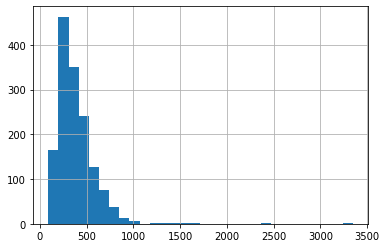

In [26]:
#list of words count in each sentence 
seq_len = [len(i.split()) for i in train['Text']]
pd.Series(seq_len).hist(bins = 30)

In [27]:
configure_plotly_browser_state()
import plotly.express as px
#df = px.data.tips()
fig = px.histogram(x=seq_len,nbins=30)
fig.show()



*   peak 299
*   Bert maximum length tokenization is 512
*   I will intiate maximum length to 512  







In [199]:
def tokenize(max_length,df,Text,label): #function to tokenize data
  #seq_len=512
  num_samples=len(df)

  Xids=np.zeros((num_samples,max_length))
  Xmask=np.zeros((num_samples,max_length))


  for i,Text in enumerate(df['Text']):
    tokens=tokenizer.encode_plus(Text,
                                 max_length=max_length,
                                 truncation=True,
                                 padding='max_length',
                                 add_special_tokens=True,
                                 return_tensors='tf') 
                      
  
 # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']


# first extract lables column
  arr = df.label.values

# we then initialize the zero array
  label= np.zeros((len(df),arr.max()+1))

# set relevant index for each row to 1 (one-hot encode)
  label[np.arange(len(df)),arr] = 1
  label
# create the dataset object
  dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,label))
  return dataset

In [205]:
def map_func(input_ids, masks,labels):# to map inputs_ids and attention_mask
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [206]:
data_set=tokenize(512,train_df,train_df.Text,train_df.label)
# then we use the dataset map method to apply this transformation
dataset_train =data_set.map(map_func)
#for i in dataset_train.take(1):
 # print(i)
print('shape of data set',dataset_train.take(1))

shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


In [207]:
data_set=tokenize(512,valid_df,valid_df.Text,valid_df.label)
# then we use the dataset map method to apply this transformation
dataset_valid =data_set.map(map_func)
#for i in dataset_train.take(1):
 # print(i)
print('shape of data set',dataset_valid.take(1))


shape of data set <TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>


In [208]:
dataset_train,dataset_valid

(<MapDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>,
 <MapDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>)

In [209]:

batch_size=16
dataset_train=dataset_train.shuffle(10000).batch(batch_size,drop_remainder=True)
dataset_valid=dataset_valid.shuffle(10000).batch(batch_size,drop_remainder=True,)

In [218]:
# intiate Bert model
Bert_layer=TFAutoModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [219]:
Bert_layer

In [220]:
Bert_layer.summary()

Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [226]:
input_ids=tf.keras.layers.Input(shape=(512,),name="input_ids",dtype='int32')
attention_mask=tf.keras.layers.Input(shape=(512,),name="attention_mask",dtype='int32')
pooled_out=Bert_layer([input_ids,attention_mask])[1]
net= tf.keras.layers.Dense(1024,activation='relu')(pooled_out)
#net = tf.keras.layers.Dropout(0.1)(net)#helps prevent overfitting
output= tf.keras.layers.Dense(5,activation='softmax',name='output')(net)
model = tf.keras.Model(inputs=[input_ids,attention_mask],outputs=output)

In [227]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                        

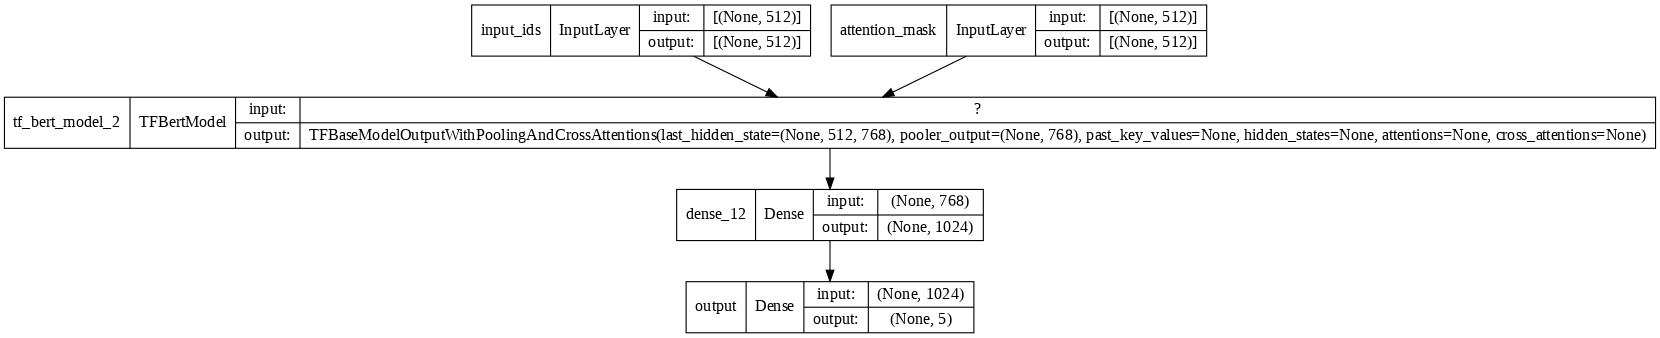

In [300]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=80, )

In [225]:
# (optional) freeze bert layer
#model.layers[2].trainable = False

In [229]:
metric=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='Recall'),
        tf.keras.metrics.TruePositives(name='TruePositives'),
         tf.keras.metrics.FalsePositives(name='FalsePositives')]

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5,decay=1e-6,) # author recommend3e-4, 1e-4, 5e-5, 3e-5
loss = tf.keras.losses.CategoricalCrossentropy()#used formulti-class classification model where there are two or more output labels
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [230]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights =compute_class_weight('balanced',classes=np.unique(train_df['label']),y=train_df['label'])

class_weights_dict ={}
for index,value in enumerate(class_weights):
  class_weights_dict[index] = value
class_weights_dict

{0: 0.8862453531598513,
 1: 1.14066985645933,
 2: 1.0885844748858446,
 3: 0.8606498194945849,
 4: 1.0935779816513762}

In [231]:
checkpoint_filepath = '/content/drive/MyDrive/Bert'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [232]:
history=model.fit(
    dataset_train,
    validation_data=dataset_valid,
    class_weight=class_weights_dict,
    callbacks=[model_checkpoint_callback],
    epochs=4, # author recommend 2 to 4 further model will overfit
    #steps_per_epoch=20,
    verbose=1,
)

Epoch 1/4
74/74 [==============================] - 933s 12s/step - loss: 0.4442 - accuracy: 0.8623 - Precision: 0.9573 - Recall: 0.7568 - TruePositives: 896.0000 - FalsePositives: 40.0000 - val_loss: 0.1516 - val_accuracy: 0.9583 - val_Precision: 0.9617 - val_Recall: 0.9583 - val_TruePositives: 276.0000 - val_FalsePositives: 11.0000
Epoch 2/4
74/74 [==============================] - 1000s 14s/step - loss: 0.0666 - accuracy: 0.9848 - Precision: 0.9848 - Recall: 0.9831 - TruePositives: 1164.0000 - FalsePositives: 18.0000 - val_loss: 0.0953 - val_accuracy: 0.9861 - val_Precision: 0.9861 - val_Recall: 0.9826 - val_TruePositives: 283.0000 - val_FalsePositives: 4.0000
Epoch 3/4
74/74 [==============================] - 936s 13s/step - loss: 0.0485 - accuracy: 0.9890 - Precision: 0.9899 - Recall: 0.9890 - TruePositives: 1171.0000 - FalsePositives: 12.0000 - val_loss: 0.1148 - val_accuracy: 0.9757 - val_Precision: 0.9756 - val_Recall: 0.9722 - val_TruePositives: 280.0000 - val_FalsePositives: 7

In [235]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train '+metric, 'val_'+metric])
  plt.show()

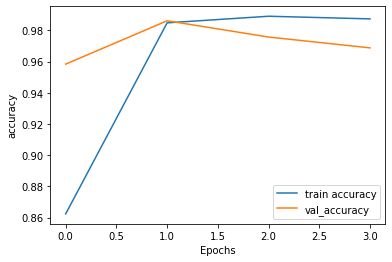

In [236]:
plot_graphs(history,'accuracy')

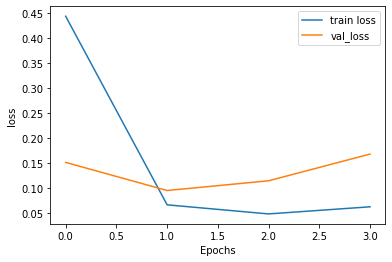

In [237]:
plot_graphs(history, 'loss')

In [238]:
#Model evalution
model.evaluate(dataset_valid, verbose=1)

18/18 [==============================] - 66s 4s/step - loss: 0.1895 - accuracy: 0.9653 - Precision: 0.9652 - Recall: 0.9618 - TruePositives: 277.0000 - FalsePositives: 10.0000


[0.1895182579755783,
 0.9652777910232544,
 0.9651567935943604,
 0.9618055820465088,
 277.0,
 10.0]

In [266]:
#Saving model to google drive 
model.save('/content/drive/MyDrive/Models/BBC_Classification_with_bert3.h5')  # creates a HDF5 file 'my_model.h5'

In [272]:
# returns a compiled model
# identical to the previous one
bertmodel=load_model('/content/drive/MyDrive/Models/BBC Classification with bert')

**News article categories prediction**

In [253]:
def prediction(df,label): # function to predict news article categories
  classes_list=[]
  for Text in  df['Text']:# Data preparation as an input to bert model
    tokens = tokenizer.encode_plus(Text,max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    tokenizations={
                    'input_ids':tf.cast(tokens['input_ids'], tf.float64),
                   'attention_mask':tf.cast(tokens['attention_mask'], tf.float64),
                   }

    probabilities=model.predict(tokenizations)
    highest_class=np.argmax(probabilities)
    classes_list.append(highest_class)
  df[label]=classes_list
  inv_map = {v: k for k, v in label_dict.items()}
  df['category']=df.label.map(inv_map)
  return df 

In [254]:
test_prediction=prediction(test,'label') # test data predictions 
test_prediction

,ArticleId,Text,label,category
0,1018,qpr keeper day heads for preston queens park r...,3,sport
1,1319,software watching while you work software that...,1,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,3,sport
3,459,india s reliance family feud heats up the ongo...,0,business
4,1020,boro suffer morrison injury blow middlesbrough...,3,sport
...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,0,business
731,373,u2 to play at grammy awards show irish rock ba...,4,entertainment
732,1704,sport betting rules in spotlight a group of mp...,2,politics
733,206,alfa romeos to get gm engines fiat is to sto...,0,business


In [256]:
test_prediction.to_csv('/content/drive/MyDrive/Submission/submission.csv',index=False)

In [ ]:
""""""""""
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
  tokens= tokenizer.encode_plus(text,max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
  return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
          'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}
tensor=prep_data('qpr keeper day heads for preston queens park rangers keeper chris day is set to join preston on a month s loan.  day has been displaced by the arrival of simon royce  who is in his second month on loan from charlton. qpr have also signed italian generoso rossi. r s manager ian holloway said:  some might say it s a risk as he can t be recalled during that month and simon royce can now be recalled by charlton.  but i have other irons in the fire. i have had a  yes  from a couple of others should i need them.   day s rangers contract expires in the summer. meanwhile  holloway is hoping to complete the signing of middlesbrough defender andy davies - either permanently or again on loan - before saturday s match at ipswich. davies impressed during a recent loan spell at loftus road. holloway is also chasing bristol city midfielder tom doherty.')

tensor
"""""""""      